<a href="https://colab.research.google.com/github/Joseviniciusrs/Classification/blob/main/Atividade_Desafio1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafio 1: Classificação de tecnologias do Stackoverflow


> * Daniel Barbosa Bastos
> * João Pedro de Lima Oliveira
> * José Vinicius Rocha Schweitzer
> * Patrick Guilherme da Silva





# Importação das Bibliotecas
Nesta seção é feita todas as importações que serão utilizadas no projeto.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import seaborn as sns
import warnings
import altair as alt
import nltk #Biblioteca de processamento de lingagem natural
import re
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer#Biblioteca de algoritmos de datascience
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
import random
from IPython.display import clear_output
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate

sns.set_style("whitegrid")
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Base de dados e Balanceamento
Nesta seção é feito o carregamento da base de dados e a visualização do seu balanceamento. A base possui 3 tipos: Language and Framework, Platform e Tools, sendo que todos eles possuem 89 itens, estando balanceada.

In [ ]:
#Carrega o arquivo CSV
df = pd.read_csv('base_textos_stack.csv',sep=',')

In [ ]:
#Exibição do dataframe
df.head()

,excerpt,classification
0,Software-defined networking (SDN),1
1,SPDY is an experimental protocol for multiplex...,1
2,ASP.NET SignalR is a library for ASP.NET devel...,0
3,Apache Kafka is a publish-subscribe messaging ...,2
4,Kubernetes is an open source implementation of...,1


In [ ]:
#Visualizar balanceamento da base - A base esta balanceada em relação aos seus tipos
df.classification.value_counts()

1    89
0    89
2    89
Name: classification, dtype: int64

###Análise do tamanho dos artigos

Nesta seção foi realizada a criação de uma coluna no dataframe contendo o número de palavras, e desta foi feita aplicada um resumo estatístico da coluna 'data_length'.
<p>A lista abaixo refere-se ao resumo que é exibido e o que cada variável significa.</p>

* **count:** O número total de valores na coluna 'data_length'.
* **mean:** A média dos valores na coluna 'data_length'.
* **std:** O desvio padrão, que mede a dispersão dos valores em relação à média.
* **min:** O valor mínimo na coluna 'data_length'.
* **25%:** O primeiro quartil, que é o valor abaixo do qual cai o 25% inferior dos valores.
* **50%:** A mediana, que é o valor que divide os dados ao meio.
* **75%:** O terceiro quartil, que é o valor abaixo do qual cai o 75% inferior dos valores.
* **max:** O valor máximo na coluna 'data_length'.



In [ ]:
#Criação de coluna no dataframe com o comprimento (número de palavras) da sentença correspondente na coluna 'excerpt'
df['data_length'] =  [len(sentence.split()) for sentence in df['excerpt']]

#Avaliação estatistica da coluna 'data_length'
df['data_length'].describe()

count    267.000000
mean      27.374532
std       14.913604
min        3.000000
25%       15.500000
50%       24.000000
75%       37.500000
max       68.000000
Name: data_length, dtype: float64

# Limpeza dos dados
Nesta seção é feita a remoção de caracteres desnecessários para a analise dos dados. Ao final pode-se visualizar as alterações que são geradas pela limpeza.

## Etapa 1: Limpeza de caracteres especiais
Remoção de conjunto de caracteres especiais

In [ ]:
#Cria a coluna cp1, acessa a coluna 'excerpt' e faz uma serie de remoções

#Substitui \r por espaço em branco
df['cp1'] = df['excerpt'].str.replace("\r", " ")

#Remove apostrofo S ('s)
df['cp1'] = df['cp1'].str.replace("\'s", "")

#Remove a quebra de linha por espaço em branco
df['cp1'] = df['cp1'].str.replace("\n", " ")

#Reduz os espaços em branco
df['cp1'] = df['cp1'].str.replace("    ", " ")

In [ ]:
#REGEX [^a-zA-Z#.\s]+: Ocorrências de caracteres que não sejam letras, hashtags, pontos ou espaços em branco
regex = re.compile(r'[^a-zA-Z#.\s]+')
df['cp1'] = [regex.sub(" ", content) for content in df['cp1']]

#REGEX r'\.$': Sequência de caracteres que consiste apenas em um ponto (.) no final da string
regex = re.compile(r'\.$')#Remove os caracteres especiais
df['cp1'] = [regex.sub(" ", content) for content in df['cp1']]

In [ ]:
#Exibição do dataframe com a nova coluna cp1 com a limpeza
df.head()

,excerpt,classification,data_length,cp1
0,Software-defined networking (SDN),1,3,Software defined networking SDN
1,SPDY is an experimental protocol for multiplex...,1,19,SPDY is an experimental protocol for multiplex...
2,ASP.NET SignalR is a library for ASP.NET devel...,0,45,ASP.NET SignalR is a library for ASP.NET devel...
3,Apache Kafka is a publish-subscribe messaging ...,2,14,Apache Kafka is a publish subscribe messaging ...
4,Kubernetes is an open source implementation of...,1,10,Kubernetes is an open source implementation of...


In [ ]:
#Antes e depois da limpeza (Exemplo)
print('Antes: \n'+ df.loc[2]['excerpt'] + '\n \n')
print('Depois: \n'+ df.loc[2]['cp1'])

Antes: 
ASP.NET SignalR is a library for ASP.NET developers that makes it incredibly simple to add real-time web functionality to your applications. What is "real-time web" functionality? It's the ability to have your server-side code push content to the connected clients as it happens, in real-time.
 

Depois: 
ASP.NET SignalR is a library for ASP.NET developers that makes it incredibly simple to add real time web functionality to your applications. What is  real time web  functionality  It the ability to have your server side code push content to the connected clients as it happens  in real time 


## Etapa 2: Remoção de Stopwords
As stopwords palavras são consideradas irrelevantes para a análise, pois são muito comuns na língua e não carregam informações significativas por si mesmas.



In [ ]:
# Baixando as listas de stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Carregando a lista de stopwords em inglês - Palavras chave do idioma inglês (tem na maioria dos texto do idioma ingles)
stop_words = list(stopwords.words('english'))
stop_words.append('tool')
stop_words.append('service')
stop_words.append('avail')
stop_words.append('plataform')

In [ ]:
# Remoção de stopword aspas simples
stop_words = [word.replace("'","") for word in stop_words]


## Etapa 3: Redução de palavras para forma base ou raiz
Nesta seção foi aplicado a técnica de stemming, que reduz a inflexão em palavras às suas formas-raiz. Foi empregado o stemming pois ele possui maior simplicidade e eficiência sendo computacionalmente mais simples e rápido.O algoritmo de stemming utilizado foi o snowball pois na sua stemização gera formas mais legíveis.

Para além deste fatores em teste o snowball apresentou o melhor desempenho.

In [ ]:
#Carregar os pacotes
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
#Foi empregado o snowball
from nltk.stem.snowball import SnowballStemmer
snowball = SnowballStemmer(language="english")

In [ ]:
#Realização da stemização
#1 - Divide o texto em um lista de palavras, todas sendo minusculas
#2 - Filtra as palavras stopwords
#3 - Aplica a stemização com o snowball
#4 - palavras stemizadas são recombinadas em uma única string
func_stemmizator = lambda x: " ".join([snowball.stem(w) for w in x.lower().split() if w not in stop_words])

#Cria coluna com texto stemizado
df['cp2'] = df['cp1'].apply(func_stemmizator)

Evolução do processo

In [ ]:
#Teste inicial
df.loc[40]['excerpt']

'New Relic is a web application performance monitoring service for Ruby, Java, .NET, PHP, Python, Node.js, Android, and iOS apps.'

In [ ]:
#Texto com a limpeza
df.loc[40]['cp1']

'New Relic is a web application performance monitoring service for Ruby  Java  .NET  PHP  Python  Node.js  Android  and iOS apps '

In [ ]:
#Texto stemizado
df.loc[40]['cp2']

'new relic web applic perform monitor rubi java .net php python node.j android io app'

# Códificação dos rótulos


In [ ]:
#Criação das categorias
categorias = {
  "Language and Framework": 0,
  "Tools": 1,
  "Platform": 2
}

In [ ]:
# Mapeamento das categorias
df['categorias'] = df['classification']
df = df.replace({'categorias':categorias})

In [ ]:
#Exibição do dataframe
df.head()

,excerpt,classification,data_length,cp1,cp2,categorias
0,Software-defined networking (SDN),1,3,Software defined networking SDN,softwar defin network sdn,1
1,SPDY is an experimental protocol for multiplex...,1,19,SPDY is an experimental protocol for multiplex...,spdi experiment protocol multiplex multipl con...,1
2,ASP.NET SignalR is a library for ASP.NET devel...,0,45,ASP.NET SignalR is a library for ASP.NET devel...,asp.net signalr librari asp.net develop make i...,0
3,Apache Kafka is a publish-subscribe messaging ...,2,14,Apache Kafka is a publish subscribe messaging ...,apach kafka publish subscrib messag framework ...,2
4,Kubernetes is an open source implementation of...,1,10,Kubernetes is an open source implementation of...,kubernet open sourc implement contain cluster ...,1


# Conjuntos de treinamento e teste
Foi feita a separação de 10% da base de dados da base para teste e 90% da base para treinamento.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['cp2'],
                                                    df['categorias'],
                                                    test_size=0.1,
                                                    random_state=8)

In [ ]:
print(len(y_test))

27


# <h1>Transformação dos dados</h1>
Nesta seção para o processo de transformação dos dados foi utilizado o TF-ID que indica a importância de uma palavra/termo para o conjunto, quanto maior a ocorrencia do termo no texto maior o seu valor de TF-IDf.
*   TF: mede a frequência com que uma palavra aparece em um documento específico
*   IDF: mede a raridade de uma palavra em relação a todo o conjunto de texto.

Foi utilizado o TF-IDF pois ele traz uma redução de ruído, ou seja, reduz o peso de palavras muito comuns, traz maior relevância contextual ao levar em consideração a frequência relativa de um termo.

In [ ]:
#Intervalo de n-gramas que se deseja considerar ao criar as características do texto
#Um texto composto com duas palavras é o suficiente para a base
ngram_range = (1,2)

#Mínimo de vezes que uma palavra deve aparecer no documento para ser incluída nas características
min_df = 2

#Limite superior para a frequência | 1. significa que não tem limite
max_df = 1.

#Não está definindo um limite para o número máximo de características
max_features = None

In [ ]:
#configurando um vetorizador TF-IDF
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=stop_words,
                        lowercase=True,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        sublinear_tf=True)

#filtros de treino -> Não se condidera nada do teste para execução do algoritmo transforme pega as palavras que não fazerm parte do vocabulario são descartadas

#transformar o conjunto de treinamento X_train em uma matriz TF-IDF
features_train = tfidf.fit_transform(X_train).toarray()
features_gen_train = features_train #base para usar no alg genetico

labels_train = y_train
print(features_train.shape)

#transformar o conjunto de teste X_test em uma matriz TF-IDF
features_test = tfidf.transform(X_test).toarray()
features_gen_test = features_test

labels_test = y_test
print(features_test.shape)

(240, 826)
(27, 826)


In [ ]:
features_gen_test.shape

(27, 826)

In [ ]:
from sklearn.feature_selection import chi2
import numpy as np

#Vai varrendo entre as categorias (4)
for Product, category_id in sorted(categorias.items()):
    #relevância de cada recurso para uma categoria específica
    features_chi2 = chi2(features_train, labels_train == category_id)
    #classifica os índices do array features_chi2 em ordem crescente
    indices = np.argsort(features_chi2[0])
    #nomes dos recursos
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    #Palavras unicas
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    #Frase de 2 palavras
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]

    print("# '{}' category:".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-5:])))
    print("")

# 'Language and Framework' category:
  . Most correlated unigrams:
. dynam
. html
. view
. type
. languag
  . Most correlated bigrams:
. function program
. model view
. object orient
. java platform
. program languag

# 'Platform' category:
  . Most correlated unigrams:
. integr
. task
. autom
. test
. visual
  . Most correlated bigrams:
. integr framework
. configur manag
. depend manag
. busi intellig
. version control

# 'Tools' category:
  . Most correlated unigrams:
. cluster
. secur
. comput
. linux
. cloud
  . Most correlated bigrams:
. system design
. web browser
. cluster manag
. cloud comput
. oper system



# Criação do Modelo

In [ ]:
#métricas de avaliação
score_metrics = {'F1': 'f1_macro', 'Accuracy': make_scorer(accuracy_score)}
df_estimators_scores = pd.DataFrame(columns=['Estimator', 'Cross-validation Scores', 'Test Set Scores'])
df_estimators_scores

,Estimator,Cross-validation Scores,Test Set Scores


## Random Forest Classifier

### Seleção de atributos

In [ ]:
features_train.shape

(240, 826)

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

selector = SelectKBest(chi2, k=300)
features_train = selector.fit_transform(features_train, labels_train)
features_test = selector.transform(features_test)

print(features_train.shape)
print(features_test.shape)

(240, 300)
(27, 300)


In [ ]:
# Estimadores
# - Gera uma sequência de 5 valores igualmente espaçados entre 10 e 100
# - Este é o número de árvores na floresta aleatória
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 5)]

# max_features
# - hiperparâmetro que controla o número máximo de características
max_features = ['auto', 'sqrt']

# max_depth
# - Lista chamada max_depth que contém cinco valores inteiros igualmente espaçados no intervalo de 10 a 200.
# - Hiperparâmetro controla a profundidade máxima da árvore de decisão
max_depth = [int(x) for x in np.linspace(10, 200, num = 5)]
max_depth.append(None)

# min_samples_split
# - Número mínimo de amostras necessárias para dividir um nó da árvore em dois subnós
min_samples_split = [2, 5, 10]

# min_samples_leaf
# - hiperparâmetro especifica o número mínimo de amostras necessárias em uma folha
min_samples_leaf = [2, 5, 10]

# bootstrap
# - hiperparâmetro controla se a amostragem de dados é feita com substituição (bootstrap) ao ajustar cada árvore na floresta aleatória
# - True: amostragem com substituição
# - False: amostragem sem substituição
bootstrap = [True, False]

# random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 57, 105, 152, 200, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [2, 5, 10],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 32, 55, 77, 100]}


In [ ]:
# Random Forest Classifier
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,#Estimador a otimizar
                                   param_distributions=random_grid,#hiperparametros
                                   n_iter=200,#200 combinações diferentes
                                   scoring=score_metrics,#Metricas a utilizar
                                   refit='F1',#modelo vai ser ajustado novamente usando a métrica 'F1'
                                   cv=10,#Dados serão divididos em 10 partes e o modela treinado e testado 10 vezes
                                   verbose=2,
                                   random_state=8,
                                   n_jobs =2)#Nucleos da CPU a utilizar

# Fit the random search model
# - Pesquisa aleatória de hiperparâmetros
random_search.fit(features_train, labels_train)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=8),
                   n_iter=200, n_jobs=2,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 57, 105, 152, 200,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 5, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 32, 55, 77, 100]},
                   random_state=8, refit='F1',
                   scoring={'Accuracy': make_scorer(accuracy_score),
                            'F1': 'f1_macro'},
                   verbose=2)

In [ ]:
print("Os melhores hiperparâmetros encontrados com o Random Search são:")
pprint(random_search.best_params_)
print("")
print("A macro F1 obtida com esses hiperparâmetros é:")
print(random_search.best_score_)

Os melhores hiperparâmetros encontrados com o Random Search são:
{'bootstrap': True,
 'max_depth': 152,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 55}

A macro F1 obtida com esses hiperparâmetros é:
0.6850672905239468


In [ ]:
# pd.DataFrame(random_search.cv_results_).T

In [ ]:
results = random_search.cv_results_
best_rfc = random_search.best_estimator_
best_rfc

RandomForestClassifier(max_depth=152, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=55, random_state=8)

In [ ]:
# Modelo que obteve o melhor desempenho em termos da métrica 'F1'
best_scorer_index = np.nonzero(results['rank_test_F1'] == 1)[0][0]
# best_scorer_index = np.nonzero(results['rank_test_score'] == 1)[0][0]
best_scorer_index

30

In [ ]:
best_rfc.fit(features_train, labels_train)
rfc_pred = best_rfc.predict(features_test)

### Matriz confusão

              precision    recall  f1-score   support

           0       0.33      0.29      0.31         7
           1       0.88      0.78      0.82         9
           2       0.54      0.64      0.58        11

    accuracy                           0.59        27
   macro avg       0.58      0.57      0.57        27
weighted avg       0.60      0.59      0.59        27



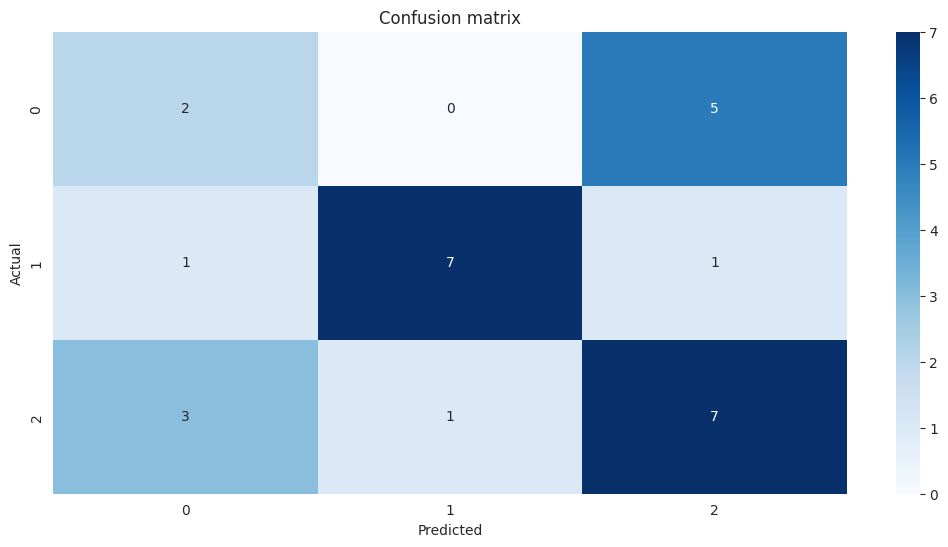

In [ ]:
acc = accuracy_score(labels_test, rfc_pred)
f1 = f1_score(labels_test, rfc_pred, average='macro')
print(classification_report(labels_test,rfc_pred))

aux_df = df[['classification', 'categorias']].drop_duplicates().sort_values('categorias')
conf_matrix = confusion_matrix(labels_test, rfc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix,
            annot=True,
            xticklabels=aux_df['categorias'].values,
            yticklabels=aux_df['categorias'].values,
            cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()

In [ ]:
print("Cross-validation scores")
print("F1: %.3f - Accuracy: %.3f " % (results['mean_test_F1'][best_scorer_index], results['mean_test_Accuracy'][best_scorer_index]))
# print("F1: %.3f - Accuracy: %.3f " % (results['mean_test_score'][best_scorer_index], results['mean_test_score'][best_scorer_index]))
print('---------------------------')
print("Test scores")
print("F1: %.3f - Accuracy: %.3f " % (f1, acc))

Cross-validation scores
F1: 0.685 - Accuracy: 0.688 
---------------------------
Test scores
F1: 0.572 - Accuracy: 0.593 


In [ ]:
d = {
     'Estimator': 'Random Forest by SelectKbest',
     'Cross-validation Scores': (round(results['mean_test_F1'][best_scorer_index],3), round(results['mean_test_Accuracy'][best_scorer_index],3)),
    #  'Cross-validation Scores': (round(results['mean_test_score'][best_scorer_index],3), round(results['std_test_score'][best_scorer_index],3)),
     'Test Set Scores': (round(f1,3), round(acc,3))
}

df_estimators_scores = df_estimators_scores.append(d, ignore_index=True)

In [ ]:
df_estimators_scores

,Estimator,Cross-validation Scores,Test Set Scores
0,Random Forest by SelectKbest,"(0.685, 0.688)","(0.572, 0.593)"


## Naive Bayes

In [ ]:
mnbc = MultinomialNB()
mnbc

MultinomialNB()

In [ ]:
scores = cross_validate(mnbc, features_train, labels_train, scoring=score_metrics, cv=3, return_train_score=True)

In [ ]:
print(scores.keys())
print(scores['test_F1'])

dict_keys(['fit_time', 'score_time', 'test_F1', 'train_F1', 'test_Accuracy', 'train_Accuracy'])
[0.74131794 0.77246307 0.82367365]


### Matriz confusão

              precision    recall  f1-score   support

           0       0.71      0.71      0.71         7
           1       0.70      0.78      0.74         9
           2       0.70      0.64      0.67        11

    accuracy                           0.70        27
   macro avg       0.70      0.71      0.71        27
weighted avg       0.70      0.70      0.70        27



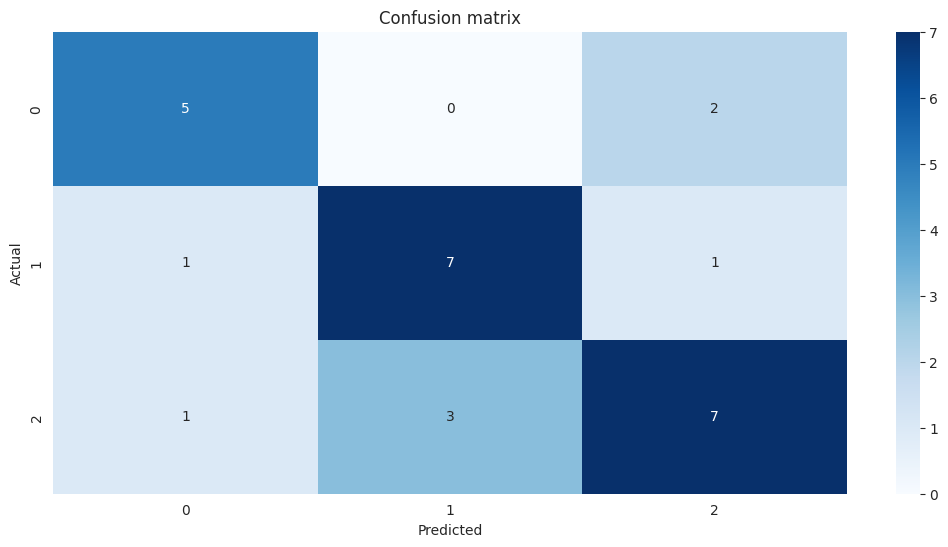

In [ ]:
mnbc.fit(features_train, labels_train)
mnbc_pred = mnbc.predict(features_test)

acc = accuracy_score(labels_test, mnbc_pred)
f1 = f1_score(labels_test, mnbc_pred, average='macro')
print(classification_report(labels_test,mnbc_pred))

aux_df = df[['classification', 'categorias']].drop_duplicates().sort_values('categorias')
conf_matrix = confusion_matrix(labels_test, mnbc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix,
            annot=True,
            xticklabels=aux_df['classification'].values,
            yticklabels=aux_df['classification'].values,
            cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()

In [ ]:
print("Cross-validation scores")
print("F1: %.3f - Accuracy: %.3f " % (results['mean_test_F1'][best_scorer_index], results['mean_test_Accuracy'][best_scorer_index]))
print('---------------------------')
print("Test scores")
print("F1: %.3f - Accuracy: %.3f " % (f1, acc))

Cross-validation scores
F1: 0.685 - Accuracy: 0.688 
---------------------------
Test scores
F1: 0.706 - Accuracy: 0.704 


In [ ]:
d = {
     'Estimator': 'Naive Bayes',
     'Cross-validation Scores': (round(results['mean_test_F1'][best_scorer_index],3), round(results['mean_test_Accuracy'][best_scorer_index],3)),
     'Test Set Scores': (round(f1,3), round(acc,3))
}

df_estimators_scores = df_estimators_scores.append(d, ignore_index=True)

## Algoritmo genético
<p>Implementação do algoritmo genético</p>


In [ ]:
#Tamanho da população
population_size = 100

#Quantidade de Gerações
num_generations = 20
parents_rate = 0.2
stop_cond = 5
#Mutação(%)
mutation_rate = 0.1

In [ ]:
gen_train, gen_test, label_gen_train, label_gen_test = train_test_split(features_gen_train,
                                                    labels_train,
                                                    test_size=0.1,
                                                    random_state=8)

In [ ]:
gen_train.shape

(216, 826)

In [ ]:
def fitness(features):
    #Dados de treinamento selecionando as caracteristicas especificadas pela features

    X_train_subset = gen_train[:, features.astype(bool)]
    X_test_subset = gen_test[:, features.astype(bool)]
    randomforest = RandomForestClassifier(random_state=42, n_jobs=2)

    randomforest.fit(X_train_subset, label_gen_train)

    return randomforest.score(X_test_subset, label_gen_test)

In [ ]:
#Inicializa a população: matriz de 100x831 (com valor aleatorios) | 831 -> Quantidade de atributos
population = np.random.randint(2, size=(population_size, gen_train.shape[1]))

In [ ]:
#Aptidão das features de uma população
# fitness_scores = [fitness(features) for features in population]
fitness_scores = np.apply_along_axis(fitness, axis=1, arr=population)

In [ ]:
#Looping para as Gerações
condom = 0
last_fit = fitness_scores[np.argmax(fitness_scores)]
for generation in range(num_generations):
    clear_output(wait=True)
    print('contador', condom)
    print('ultimo maior fitness: ', last_fit)
    print("geração: ", generation)
    #Array com individuos selecionados da população na proporção de parents_rate
    parent_indices = np.random.choice(population_size, size=int(parents_rate * population_size), p=fitness_scores/sum(fitness_scores))

    #Seleciona os pais a serem utilizados
    parents = population[parent_indices]
    #Matriz para os filhos no mesmo formato que a dos pais
    children = np.empty_like(parents)
    children2 = np.empty_like(parents)
    for i in range(len(parents)):
        parent1 = parents[i]
        parent2 = random.choice(parents)

        crossover_point = np.random.randint(1, gen_train.shape[1]-1)
        child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))

        children[i] = child1
        children2[i] = child2

    children = np.concatenate((children, children2), axis=0)
    #Gerar a mutação nos filhos
    for i in range(len(children)):
        if np.random.rand() < mutation_rate:
            mutation_point = np.random.randint(gen_train.shape[1])
            children[i, mutation_point] = 1 - children[i, mutation_point]
            print("\tmutação no filho ", i)

    #Aplitidão dos filhos
    combined_population = np.unique(np.vstack((population, children)), axis=0)
    fitness_scores = np.apply_along_axis(fitness, axis=1, arr=combined_population)
    sorted_indices = np.argsort(fitness_scores)[::-1]

    combined_population = combined_population[sorted_indices[:population_size]]
    fitness_scores = fitness_scores[sorted_indices[:population_size]]
    #Atualiza a população
    population = combined_population
    if last_fit == fitness_scores[np.argmax(fitness_scores)]:
        condom += 1
        if condom >= stop_cond:
            print('condição de parada: ', condom, ' gerações sem evolução')
            break
    else:
        condom = 0
    last_fit = fitness_scores[np.argmax(fitness_scores)]


contador 4
ultimo maior fitness:  0.7916666666666666
geração:  5
	mutação no filho  1
	mutação no filho  11
	mutação no filho  33
condição de parada:  5  gerações sem evolução


In [ ]:
fitness_scores[np.argmax(fitness_scores)]

0.7916666666666666

In [ ]:
#Pegas os individuos com maior aptidão
best_features = population[np.argmax(fitness_scores)]

In [ ]:
#Classificador e acuracia
X_train_subset = gen_train[:, best_features.astype(bool)]
X_test_subset = gen_test[:, best_features.astype(bool)]
clf1 = RandomForestClassifier(random_state=42)
clf1.fit(X_train_subset, label_gen_train)
rfc_pred_gen = clf1.predict(X_test_subset)

acc_gen_train = accuracy_score(label_gen_test, rfc_pred_gen)
f1_gen_train = f1_score(label_gen_test, rfc_pred_gen, average='macro')
print(classification_report(label_gen_test, rfc_pred_gen))

              precision    recall  f1-score   support

           0       0.73      1.00      0.85        11
           1       0.75      0.60      0.67         5
           2       1.00      0.62      0.77         8

    accuracy                           0.79        24
   macro avg       0.83      0.74      0.76        24
weighted avg       0.83      0.79      0.78        24



In [ ]:
#Classificador e acuracia
X_train_subset = features_gen_train[:, best_features.astype(bool)]
X_test_subset = features_gen_test[:, best_features.astype(bool)]
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_subset, labels_train)
accuracy = clf.score(X_test_subset, labels_test)

In [ ]:
#Acuracia features selecionadas
print("Selected features: ", (best_features.tolist()).count(1))
print("Accuracy: ", accuracy)

Selected features:  393
Accuracy:  0.5555555555555556


In [ ]:
rfc_pred_gen = clf.predict(X_test_subset)


### Matriz confusão

              precision    recall  f1-score   support

           0       0.57      0.57      0.57         7
           1       0.57      0.44      0.50         9
           2       0.54      0.64      0.58        11

    accuracy                           0.56        27
   macro avg       0.56      0.55      0.55        27
weighted avg       0.56      0.56      0.55        27



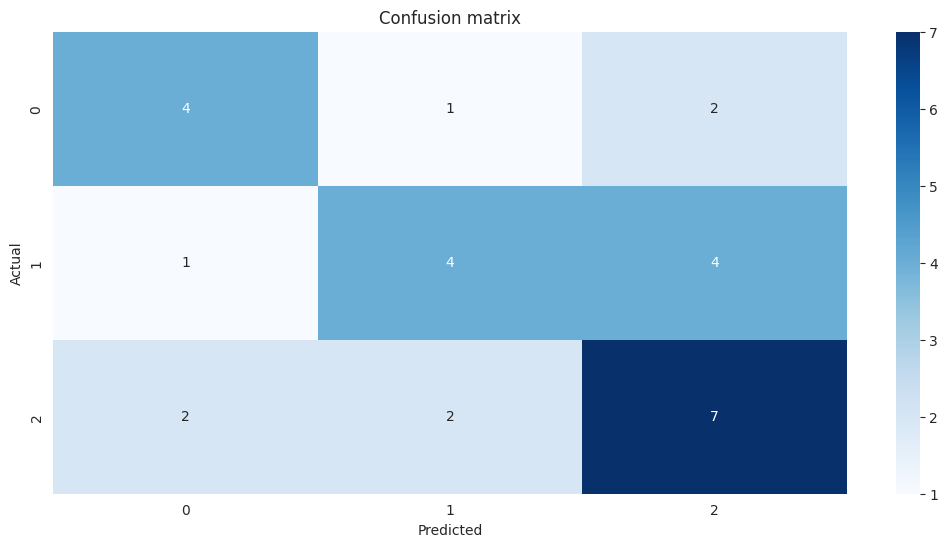

In [ ]:
acc_gen = accuracy_score(labels_test, rfc_pred_gen)
f1_gen = f1_score(labels_test, rfc_pred_gen, average='macro')
print(classification_report(labels_test, rfc_pred_gen))

aux_df = df[['classification', 'categorias']].drop_duplicates().sort_values('categorias')
conf_matrix = confusion_matrix(labels_test, rfc_pred_gen)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix,
            annot=True,
            xticklabels=aux_df['categorias'].values,
            yticklabels=aux_df['categorias'].values,
            cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()

In [ ]:
print("Training scores")
print("F1: %.3f - Accuracy: %.3f " % (round(f1_gen_train ,3), round(acc_gen_train,3)))
print('---------------------------')
print("Test scores")
print("F1: %.3f - Accuracy: %.3f " % (f1_gen, acc_gen))

Training scores
F1: 0.761 - Accuracy: 0.792 
---------------------------
Test scores
F1: 0.552 - Accuracy: 0.556 


In [ ]:
d_gen = {
     'Estimator': 'Random Forest by genetical algorithm',
     'Cross-validation Scores': (round(f1_gen_train ,3), round(acc_gen_train,3)),
     'Test Set Scores': (round(f1_gen,3), round(acc_gen,3))
}

df_estimators_scores = df_estimators_scores.append(d_gen, ignore_index=True)

In [ ]:
df_estimators_scores

,Estimator,Cross-validation Scores,Test Set Scores
0,Random Forest by SelectKbest,"(0.685, 0.688)","(0.572, 0.593)"
1,Random Forest by genetical algorithm,"(0.761, 0.792)","(0.552, 0.556)"


# Análise Comparativa

In [ ]:
df_estimators_scores

,Estimator,Cross-validation Scores,Test Set Scores
0,Random Forest by SelectKbest,"(0.685, 0.688)","(0.572, 0.593)"
1,Random Forest by genetical algorithm,"(0.761, 0.792)","(0.552, 0.556)"
2,Naive Bayes,"(0.685, 0.688)","(0.706, 0.704)"


Ao utilizar o estimador do Random Forest avaliando o cross validation no algoritmo genético foi obtido uma acurácia de 79,2% e o F1-Score de 76,1% indica um equilíbrio entre precisão e recall, que é importante em problemas de classificação desequilibrada.

Já no Select KBest, o mesmo estimador mostrou uma acurácia de 68,8% que descreve que o conjunto de características selecionadas não é tão eficiente para o problema abordado, e seu  F1-Score de 68,5% , sugerindo que o equilíbrio entre precisão e recall não é tão equilibrado.

Com essas informações, ainda parece que o modelo Random Forest treinado com o algoritmo genético é superior ao modelo que utiliza o SelectKBest em termos de desempenho de classificação. Os valores de acurácia e F1-Score são mais altos para o primeiro modelo, o que indica que ele está fazendo um trabalho melhor na tarefa de classificação em relação ao segundo modelo.


# <h1>Análise do Modelo</h1>

In [ ]:
rfc_pred_gen
rfc_pred

In [ ]:

# Categorias
category_codes = {
    'Language and Framework': 0,
    'Tools': 1,
    'Platform': 2
}

# Categorias
category_names = {
    0: 'Language and Framework',
    1: 'Tools',
    2: 'Platform'
}

# Indexes of the test set
index_X_test = X_test.index

# We get them from the original df
df_test = df.loc[index_X_test]

# Add the predictions
df_test['Prediction'] = rfc_pred
df_test['Prediction_gen'] = rfc_pred_gen
# Clean columns
df_test = df_test[['excerpt', 'classification', 'categorias', 'Prediction', 'Prediction_gen']]

# Decode
df_test['Category_Predicted'] = df_test['Prediction']
df_test['Category_Predicted_gen'] = df_test['Prediction_gen']
df_test = df_test.replace({'Category_Predicted':category_codes})
df_test = df_test.replace({'Category_Predicted_gen':category_codes})

# Clean columns again
df_test = df_test[['excerpt', 'classification', 'Category_Predicted', 'Category_Predicted_gen']]

In [ ]:
df_test.head()

,excerpt,classification,Category_Predicted,Category_Predicted_gen
197,A Powershell Unit testing framework.,0,2,2
80,Sass (Syntactically Awesome Style Sheets) is a...,0,2,0
92,Sensu is an open source monitoring framework w...,2,2,2
218,An HTTP+SPDY+Proguard client for Android and J...,0,2,0
56,A powerful and flexible toolkit for building W...,0,0,0


In [ ]:
condition = (df_test['classification'] != df_test['Category_Predicted'])

df_misclassified = df_test[condition]

df_misclassified = df_misclassified[['excerpt', 'classification', 'Category_Predicted']]

df_misclassified.head(5)

,excerpt,classification,Category_Predicted
197,A Powershell Unit testing framework.,0,2
80,Sass (Syntactically Awesome Style Sheets) is a...,0,2
218,An HTTP+SPDY+Proguard client for Android and J...,0,2
22,The ASP.NET MVC Framework is an open source we...,2,0
109,Amazon S3 (simple storage service) is an onlin...,1,2


In [ ]:
df_misclassified.Category_Predicted.value_counts()

2    6
0    4
1    1
Name: Category_Predicted, dtype: int64

In [ ]:
condition = (df_test['classification'] != df_test['Category_Predicted_gen'])

df_misclassified_gen = df_test[condition]

df_misclassified_gen = df_misclassified_gen[['excerpt', 'classification', 'Category_Predicted_gen']]

df_misclassified_gen.head(5)

,excerpt,classification,Category_Predicted_gen
197,A Powershell Unit testing framework.,0,2
22,The ASP.NET MVC Framework is an open source we...,2,0
77,RDFa (Resource Description Framework in Attrib...,1,2
109,Amazon S3 (simple storage service) is an onlin...,1,2
3,Apache Kafka is a publish-subscribe messaging ...,2,0


In [ ]:
df_misclassified_gen.Category_Predicted_gen.value_counts()

2    6
0    3
1    3
Name: Category_Predicted_gen, dtype: int64

In [ ]:
def output_article(row_article):
    print('Actual Category: %s' %(row_article['classification']))
    print('Predicted Category: %s' %(row_article['Category_Predicted']))
    print('-------------------------------------------')
    print('Text: ')
    print('%s' %(row_article['excerpt']))


In [ ]:
random.seed(1)
list_samples = random.sample(list(df_misclassified.index), 3)
list_samples

[218, 55, 80]

In [ ]:
output_article(df_misclassified.loc[list_samples[0]])

Actual Category: 0
Predicted Category: 2
-------------------------------------------
Text: 
An HTTP+SPDY+Proguard client for Android and Java applications.


In [ ]:
output_article(df_misclassified.loc[list_samples[1]])

Actual Category: 0
Predicted Category: 2
-------------------------------------------
Text: 
Yeoman is a command-line tool for frontend web development. As a "web application boilerplate," its main features include project scaffolding, a build process based in part on Grunt.js, and package management for updating project dependencies.


In [ ]:
output_article(df_misclassified.loc[list_samples[2]])

Actual Category: 0
Predicted Category: 2
-------------------------------------------
Text: 
Sass (Syntactically Awesome Style Sheets) is an extension of CSS adding features like nested rules, variables, mixins and class extensions. This enables developers to write structured, manageable and reusable CSS. Sass is compiled into standard CSS.
